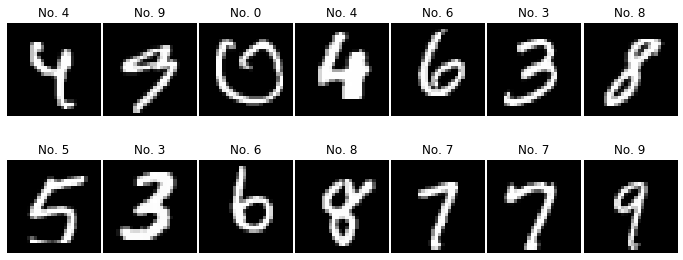

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
________________________________________________

NameError: name 'show_plots' is not defined

In [4]:
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = load_data()

# display 14 random images from the training set
import numpy as np
np.random.seed(123)

rand_14 = np.random.randint(0, train_digits.shape[0],14)
sample_digits = train_digits[rand_14]
sample_labels = train_labels[rand_14]
# code to view the images
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()
image_height = train_digits.shape[1]  
image_width = train_digits.shape[2]
num_channels = 1  # we have grayscale images
# NOTE: image_height == image_width == 28

# re-shape the images data
train_data = np.reshape(train_digits, (train_digits.shape[0], image_height, image_width, num_channels))
test_data = np.reshape(test_digits, (test_digits.shape[0],image_height, image_width, num_channels))

# re-scale the image data to values between (0.0,1.0]
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

# one-hot encode the labels - we have 10 output classes
# so 3 -> [0 0 0 1 0 0 0 0 0 0], 5 -> [0 0 0 0 0 1 0 0 0 0] & so on
from keras.utils import to_categorical
num_classes = 10
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape
# shuffle the training dataset (5 times!)
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now set-aside 10% of the train_data/labels as the
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set from train_data/labels
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
print(model.summary())

results = model.fit(train_data2, train_labels_cat2, 
                    epochs=15, batch_size=64,
                    validation_data=(val_data, val_labels_cat))



In [16]:
def show_plots(history, plot_title=None, fig_size=None):
    
    assert type(history) is dict

    # NOTE: the history object should always have loss & acc (for training data), but MAY have
    # val_loss & val_acc for validation data
    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    epochs = range(1, len(history['accuracy']) + 1)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4) if fig_size is None else fig_size))
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
    if val_loss_vals is not None:
        ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend(loc='best')
    else:
        ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)
    
    # plot accuracies on ax[1]
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy'] if 'val_accuracy' in history.keys() else None

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    if val_acc_vals is not None:
        ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend(loc='best')
    else:
        ax[1].set_title('Training Accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)
    if plot_title is not None:
        plt.suptitle(plot_title)
    plt.show()
    plt.close()
    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs, acc_vals
    if val_loss_vals is not None:
        del val_loss_vals
    if val_acc_vals is not None:
        del val_acc_vals

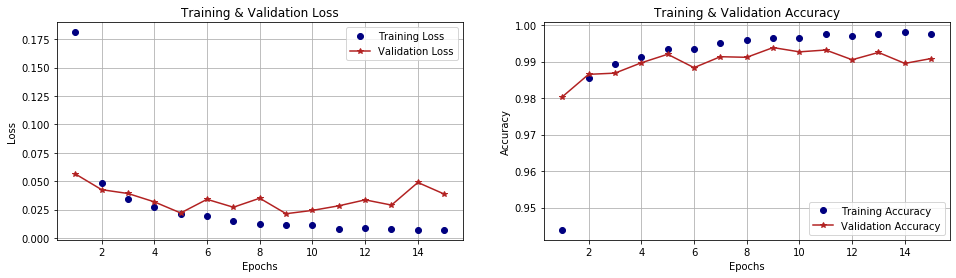

In [17]:
show_plots(results.history)

In [26]:
test_loss, test_accuracy = \
  model.evaluate(test_data, test_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

10000/10000 [==============================] - 17s 2ms/step
Test loss: 0.0493 accuracy: 0.9891


In [27]:
predictions = model.predict(test_data)
first20_preds = np.argmax(predictions, axis=1)[:25]
first20_true = np.argmax(test_labels_cat,axis=1)[:25]
print(first20_preds)
print(first20_true)

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 5 4 9 6 6 5 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4]
